## Classification Model Development

<b>Student</b>: Gustavo A. Trigos 

<b>Class Cohort</b>: MsBA3

<b>Class</b>: Machine Learning - DAT5303

<b>Assignment Objective</b>: using the information in the Apprentice Chef's case to build a predictive model on a binary response variable (Whether a customer will sign into a new service). 

## Libraries

In [1]:
import time
# Start time including loading the libraries
start = time.time()

In [2]:
# Data exploration and manipulation essentials
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand

# Statistic tests
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor # Calculating VIF

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# Classification Models
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

# Cross-validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer  

# Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

# Misc
import gender_guesser.detector as gender

In [3]:
# setting random seed
rand.seed(a = 219)

## Loading Data

In [4]:
# Loading the Apprentice Chef data set
df = pd.read_excel(io='./datasets/Apprentice_Chef_Dataset.xlsx')
dictionary = pd.read_excel(io='./datasets/Apprentice_Chef_Data_Dictionary.xlsx')

In [5]:
# Renaming column Largest order size to average meals ordered as indicated in the dictionary
df.rename(columns={'LARGEST_ORDER_SIZE': 'AVG_MEALS_ORDERED'}, inplace=True)

## Data Preprocessing

### Missing Values

In [6]:
# Looking into columns with any missing values
df.isna().sum()[df.isna().sum() > 0]

FAMILY_NAME    47
dtype: int64

Given the only column with missing values is an identifier column with no significant value to the analysis, we abstain from imputating missing values to this column.

In [7]:
# Dropping columns with missing values
df.drop(['FAMILY_NAME'],axis=1, inplace=True)

### Splitting Data into Numerical Data and Categorical

In [8]:
# Select all features excluding 'object' or categorical data
df_num = df.select_dtypes(exclude = 'object').copy()
df_cat = df.select_dtypes(include = 'object').copy()

In [9]:
# Excluding Revenue (Y-variable) from main analysis
response_var = 'CROSS_SELL_SUCCESS'
df_response = df_num[[response_var]]

# Dropping Response Variable
df_num.drop(response_var,axis=1,inplace=True)

### Exploring Response Variable's proportions

In [10]:
# Cross Sell Success proportion breakdown
(df_response[response_var].value_counts() / df_response[response_var].shape[0]).round(decimals = 2)

1    0.68
0    0.32
Name: CROSS_SELL_SUCCESS, dtype: float64

After observing the proportion of the response variable, we can observe that the two classes are moderately imbalanced.

## Numerical Data

### Outliers

In [11]:
# Interquantile Range method: removing values below or above the IQR * 1.5 thresholds

Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1

df_num[~((df_num < (Q1 - 1.5 * IQR)) |(df_num > (Q3 + 1.5 * IQR))).any(axis=1)].shape

(841, 23)

In [12]:
# Z-score method: removing values with absolute Z-score greater than 3
z_score_condition = np.abs(stats.zscore(df_num)) < 3
df_num[z_score_condition.all(axis = 1)].shape

(1701, 23)

In [13]:
# Number of features where customer is an outlier
num_outliers = pd.DataFrame(z_score_condition).sum(axis=1)

We use two different methods for outlier detection, the first one detects outliers by using the interquantile range (IQR) method of identifying all the values that surpass their respective distribution's IQR below their first quartile minus the IQR times 1.5 or above their third quartile plus the IQR times 1.5. The second method converts all the values in Z-scores and takes all those that are greater than absolute 3. We chose the second method since it was detecting less outliers and was a more conservative approach.

### Correlation with dependent and independent variables

In [14]:
# Correlation between dependent variable and independent variables
df_num.join(df_response).corr()[[response_var]].sort_values(by=response_var,ascending=False).round(decimals=4)

,CROSS_SELL_SUCCESS
CROSS_SELL_SUCCESS,1.0000
CANCELLATIONS_BEFORE_NOON,0.1634
MOBILE_NUMBER,0.1027
TASTES_AND_PREFERENCES,0.0814
REFRIGERATED_LOCKER,0.0683
PC_LOGINS,0.0445
PACKAGE_LOCKER,0.0435
MASTER_CLASSES_ATTENDED,0.0372
CONTACTS_W_CUSTOMER_SERVICE,0.0365
AVG_PREP_VID_TIME,0.0321


We can observe that there are various features that do not have strong absolute correlation coefficients with the dependent variable. It is important to observe the scatterplot for each of the features together with the independent value to make sure that each of the features follow the assumptions of ordinary least square regression.

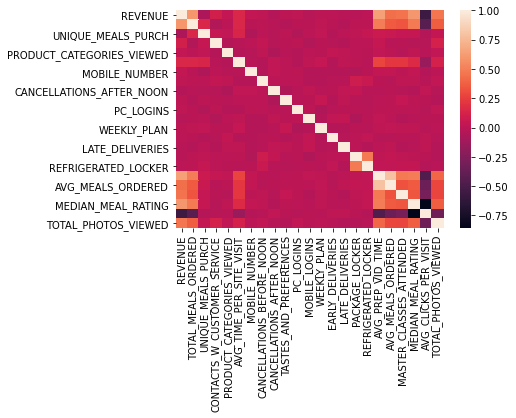

In [15]:
# Correlation Matrix Heatmap
sns.heatmap(df_num.corr())

We use a heatmap to observe the overall linear relationship between every pair of variable. In this case, we do not observe significant levels of multicolinearity. We can observe relatively strong correlation values between independent variables (see total meals ordered with average clicks per visit, master classes attended, and average prep video time). However, with domain knowledge, we know that these variables are not related directly and thus assume that strong correlation values happen due to chance. 

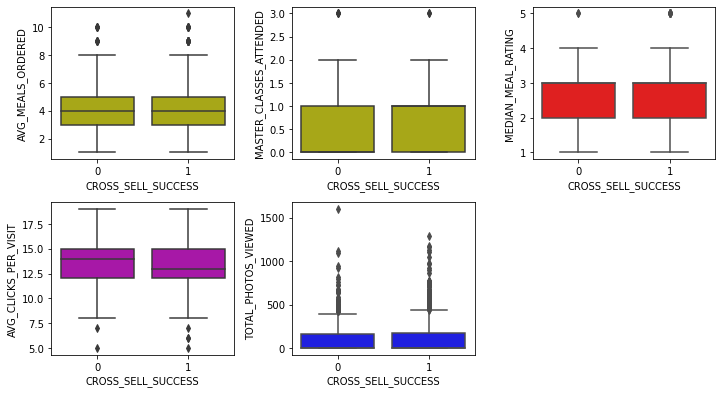

In [16]:
# Scatterplot visualization with dependent variable and independent variables 

def visual_scatter(df,response):
    # setting figure size
    fig, ax = plt.subplots(figsize = (10, 8))
    colors = ['b','g','r','c','m','y','k']

    for idx,col in enumerate(df.columns.values):
        idx += 1

        # developing a scatterplot
        plt.subplot(3,3, idx)
        sns.boxplot(x = response.loc[df.index],
                        y = df[col],
                        color = rand.choice(colors))


        # adding labels
        plt.xlabel(xlabel = response_var)
        plt.ylabel(ylabel = '{}'.format(col))
    

# cleaning up the layout and displaying the plots
visual_scatter(df_num.iloc[:,18:],df_response[response_var])
plt.tight_layout()
plt.show()

Observing non-linear behavior in various of the relationships between the dependent and independent variables, it will be beneficial to do natural log transform for most if not all of the variables. This will also significantly help with variables that are suffering with heteroscedasticity. 

### Binning Quantitative Data

In [17]:
# Revenue
df_num['revenue_class'] = pd.cut(
                           df_num['REVENUE'], 
                           bins=[131,1350,1740,2670,4000,8794], 
                           labels=["low_revenue", "mid_revenue", "mid_high_revenue","high_revenue","ultra_revenue"])

# Total Meal Orders (annual subscription)
df_num['annual_class'] = pd.cut(
                           df_num['TOTAL_MEALS_ORDERED'], 
                           bins=[11,155,259,493], 
                           labels=["no_annual_subscription", "basic_annual_subscription", "premium_annual_subscription"])


# Meal Rating
df_num['rating_class'] = pd.cut(
                           df_num['MEDIAN_MEAL_RATING'], 
                           bins=[0,2,4,5], 
                           labels=["sad_rating", "normal_rating", "happy_rating"])



In [18]:
# Dummy variable encoding
df_num = df_num.join(pd.get_dummies(df_num['revenue_class'], drop_first = True))
df_num = df_num.join(pd.get_dummies(df_num['annual_class'], drop_first = True))
df_num = df_num.join(pd.get_dummies(df_num['rating_class'], drop_first = True))

In [19]:
# Dropping original variables
df_num.drop(['revenue_class','annual_class','rating_class'], axis=1, inplace = True)

For this classification problem, we decided to use a binning method to construct additional categorical variables based on numerical variables by creating categories or segments. In the first example, we created a revenue class that ranges from observations with low revenue, to mid revenue, mid to high revenue, high revenue, and ultra revenue. We also created the annual subscription variable that assumes all those observations that had more than 156 orders in a year to have a full 52-week basic annual subscription, those with more than 260 orders to have a full 52-week premium subscription. We also created a categorical variable based on median ratings.

### Transformation and Normalization

In [20]:
# Transform data to log transform
log_cols = ['TOTAL_MEALS_ORDERED',
'UNIQUE_MEALS_PURCH',
'CONTACTS_W_CUSTOMER_SERVICE',
'PRODUCT_CATEGORIES_VIEWED',
'AVG_TIME_PER_SITE_VISIT',
'CANCELLATIONS_BEFORE_NOON',
'WEEKLY_PLAN',
'EARLY_DELIVERIES',
'LATE_DELIVERIES',
'AVG_PREP_VID_TIME',
'AVG_MEALS_ORDERED',
'MEDIAN_MEAL_RATING',
'AVG_CLICKS_PER_VISIT',
'TOTAL_PHOTOS_VIEWED',
'REVENUE'] 

# Creating new columns with new log prefix and natural logarithm transformation.
for col in log_cols:
    # Adding constant 1 to avoid transforming log of zero
    df_num.loc[:,'log_'+col] = np.log(df_num[col]+1)

In [21]:
# Dropping original values after being transformed
df_num.drop(log_cols,axis=1,inplace=True)

Looking into the scatterplot between the independent variable and the dependent variable, we believe continuous features and a selected set of discrete values can benefit from natural log-transformation. The transformations will  help each of the distribution to approximately conform to a normal distribution, as well as creating a stronger linear relationship with the response variable by mitigating heteroscedasticity. We then removed the original columns and replace them with the transformed columns. 

In [22]:
# Adding extra columns with number of outlier detection
df_num['OUTLIERS_NUM'] = num_outliers

In [23]:
# Creating binary data to encompass those who have viewed photos vs. those who have not
df_num['SEEN_PHOTOS'] = (df_num['log_TOTAL_PHOTOS_VIEWED']==0).astype('int')

In [24]:
# Normalize data with Min-Max Scaler with a range of 0 to 1
df_norm = pd.DataFrame(MinMaxScaler().fit_transform(df_num))
df_norm.set_index(df_num.index, inplace = True)

df_norm.columns = df_num.columns

We scale all of the variables with the Min-Max scaler and set the new range from zero to one. This scale will help us interpret the coefficients in the same scale, and help some of the distance-based models to process correctly (like the KNN model).

## Categorical Data

In [25]:
# Subsetting observations from numerical data 
df_cat = df_cat.loc[df_norm.index]

### Names and Gender

In [26]:
# guessing gender based on (given) name

def gender_guesser():
    # placeholder list
    placeholder_lst = []

    # looping to guess gender
    for name in df_cat.loc[:,'FIRST_NAME']:
        guess = gender.Detector(case_sensitive=False).get_gender(name)
        print(guess)
        placeholder_lst.append(guess)
    
    return placeholder_lst

# converting list into a series
# placeholder_lst = gender_guesser()
#pd.Series(placeholder_lst).to_csv('name_gender_guesser.csv')

We use a gender detector library to classify the gender of each observation with a given first name. Due to processing time, we ran the code one time and saved the results into a csv file.

In [27]:
# Loading gender guess csv
gender_guess = pd.read_csv('./name_gender_guesser.csv')
df_cat['GENDER_GUESS'] = pd.Series(gender_guess['GENDER_GUESS'])

In [28]:
# Observing proportions for the first time
(df_cat['GENDER_GUESS'].value_counts() / df_cat.shape[0]).round(2)

unknown          0.57
male             0.15
female           0.05
mostly_male      0.01
mostly_female    0.01
andy             0.00
Name: GENDER_GUESS, dtype: float64

In [29]:
# Assigning classes
df_cat.loc[(df_cat['GENDER_GUESS'] == 'mostly_female') ,'GENDER_GUESS'] = 'female'
df_cat.loc[(df_cat['GENDER_GUESS'] == 'mostly_male') ,'GENDER_GUESS'] = 'male'

# int assignment
female = 1
male = 0

df_cat.loc[(df_cat['GENDER_GUESS'] == 'andy') ,'GENDER_GUESS'] = np.random.randint(2, size=df_cat.loc[(df_cat['GENDER_GUESS'] == 'andy') ,'GENDER_GUESS'].shape[0])
df_cat['GENDER_GUESS'].replace(female,'female', inplace=True)
df_cat['GENDER_GUESS'].replace(male,'male', inplace=True)

In [30]:
unknown_condition = (df_cat['GENDER_GUESS'] == 'unknown') 

# Create dummy variable for unknown gender
df_cat['GENDER_UNKNOWN'] = unknown_condition.astype('int')

# All surnames that are unknown and end with 'a' are assigned female
a_condition = df_cat['FIRST_NAME'].str.endswith('a')
df_cat.loc[((unknown_condition & a_condition)),'GENDER_GUESS'] = 'female'
           
# All surnames that are unknown and end with 'o' are assigned to male 
o_condition = df_cat['FIRST_NAME'].str.endswith('o')
df_cat.loc[((unknown_condition & o_condition)),'GENDER_GUESS'] = 'male'         

In [31]:
# Revising how proportions changed
(df_cat['GENDER_GUESS'].value_counts() / df_cat.shape[0]).round(2)

unknown    0.49
male       0.18
female     0.11
Name: GENDER_GUESS, dtype: float64

In [32]:
# Adding random choice to all the variables that are unknown
df_cat.loc[unknown_condition ,'GENDER_GUESS'] = np.random.randint(2, size=df_cat.loc[unknown_condition ,'GENDER_GUESS'].shape[0])
df_cat['GENDER_GUESS'].replace(female,'female', inplace=True)
df_cat['GENDER_GUESS'].replace(male,'male', inplace=True)

In [33]:
# Revising final proportions
(df_cat['GENDER_GUESS'].value_counts() / df_cat.shape[0]).round(2)

male      0.44
female    0.34
Name: GENDER_GUESS, dtype: float64

In [34]:
# Changing to binary variable
df_cat['GENDER_GUESS'] = df_cat['GENDER_GUESS'].replace('female',female).replace('male',male)

In [35]:
# Filling remaining NA with male (given known proportions were skewed towards male)
df_cat['GENDER_GUESS'].fillna(female, inplace=True)




We used the gender_guesser library to estimate the gender of each of the customers by using their first name. The majority of the names, however, resulted with unknown genders. For those observations that were classified as "mostly_female" and "mostly_male", we assigned them to the "female" and "male" classes respectively. For those observations with "andy", given the algorithm found that the names could be assigned either for female or male, we used the numpy random integer generator to create an array of random binary classes and assign those observations with 1 for "female" and 0 for "male". For the unknown genders, we decided to first create a dummy variable that contains information of which gender was unknown, and then fill those that were unknown but that their first name finished with 'a' or 'o' to female and male respectively. With this, we had 50% of the observations to be unknown, with this, then we decided to run the same random choice method from above to assign the remaining variables as either "female" or "male." 

In [36]:
df_cat

,NAME,EMAIL,FIRST_NAME,GENDER_GUESS,GENDER_UNKNOWN
0,Saathos,saathos@unitedhealth.com,Saathos,0.0,1
1,Alysanne Osgrey,alysanne.osgrey@ge.org,Alysanne,0.0,1
2,Edwyd Fossoway,edwyd.fossoway@jnj.com,Edwyd,1.0,1
3,Eleyna Westerling,eleyna.westerling@ge.org,Eleyna,1.0,1
4,Elyn Norridge,elyn.norridge@jnj.com,Elyn,0.0,1
...,...,...,...,...,...
1941,Obara Sand,obara.sand@yahoo.com,Obara,1.0,0
1942,Quentyn Blackwood,quentyn.blackwood@yahoo.com,Quentyn,1.0,0
1943,Rhonda Rowan,rhonda.rowan@gmail.com,Rhonda,1.0,0
1944,Turnip,turnip@yahoo.com,Turnip,1.0,0


### Names and Length

In [37]:
# Finding number of names that a customer have
df_cat['NAME_NUM'] = (df_cat['NAME'].str.count(' ') + 1)

In [38]:
# funding number of characters (without spaces)
df_cat['NAME_CHAR'] = df_cat['NAME'].str.replace(' ', '').str.len()

For additional features, we decided to introduce the number of names that a customer has and the character length of the customer's name. Our hypothesis is that the number of names and the character length of the names could explain whether if a customer is more susceptible to participate in cross sales. 

### Email Classification

In [39]:
# Creating Email Domain column by spliting email from '@' character
df_cat['EMAIL_DOMAIN'] = '@' + df_cat['EMAIL'].str.split('@',expand=True)[1]

In [40]:
professional_email = ['@mmm.com' 
            ,'@amex.com' 
            ,'@apple.com'
            ,'@boeing.com'
            ,'@caterpillar.com' 
            ,'@chevron.com' 
            ,'@cisco.com' 
            ,'@cocacola.com' 
            ,'@disney.com' 
            ,'@dupont.com' 
            ,'@exxon.com' 
            ,'@ge.org'
            ,'@goldmansacs.com'
            ,'@homedepot.com' 
            ,'@ibm.com' 
            ,'@intel.com' 
            ,'@jnj.com'
            ,'@jpmorgan.com'
            ,'@mcdonalds.com' 
            ,'@merck.com' 
            ,'@microsoft.com'
            ,'@nike.com' 
            ,'@pfizer.com' 
            ,'@pg.com' 
            ,'@travelers.com'
            ,'@unitedtech.com'
            ,'@unitedhealth.com' 
            ,'@verizon.com' 
            ,'@visa.com' 
            ,'@walmart.com']

personal_email = ['@gmail.com', '@yahoo.com', '@protonmail.com']

junk_email = ['@me.com', '@aol.com', '@hotmail.com', '@live.com', '@msn.com', '@passport.com']

In [41]:
# Professional Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(professional_email),'EMAIL_CLASS'] = 'professional'

# Personal Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(personal_email),'EMAIL_CLASS'] = 'personal'

# Junk Class
df_cat.loc[df_cat['EMAIL_DOMAIN'].isin(junk_email),'EMAIL_CLASS'] = 'junk'

In [42]:
# Email class proportions
(df_cat['EMAIL_CLASS'].value_counts() / df_cat.shape[0]).round(2)

personal        0.44
professional    0.36
junk            0.20
Name: EMAIL_CLASS, dtype: float64

In [43]:
# Creating one-hot-encoding for Email Class column, deletes one class (K - 1)
df_cat = df_cat.join(pd.get_dummies(df_cat['EMAIL_CLASS'], drop_first = True))

In [44]:
# Cleaning columns that are irrelevant
df_cat.drop(['NAME','EMAIL','FIRST_NAME','EMAIL_DOMAIN','EMAIL_CLASS'],axis=1, inplace=True)

With the email variable, we used information from the case to obtain a list of those emails that were considered as professional, personal, or junk. We used different string methods to split the email variable and obtain the domain of the email only. With this information, we then classified those observations with their domains to each of their respective buckets ("professional", "personal", or "junk"). We expect this classification to give us further information about the customer profile. We then converted the variable into a dummy variable of those that are "personal" and those that are "junk", and dropped the "personal" column to use it as the baseline class in the models. 

## Feature Engineering

In [45]:
# Joining number data with categorical data, then separating features from the target value.
df_features = df_cat.join(df_norm)

### Domain Knowledge Features

In [46]:
## Average Number of Unique Meals per order 
df_features['MEALS_PER_ORDER'] = df_features['log_TOTAL_MEALS_ORDERED'] / df_features['log_UNIQUE_MEALS_PURCH']

# TOTAL_PHOTOS_VIEWED per total logins
df_features['PHOTOS_VIEWED_LOGIN'] = df_features['log_TOTAL_PHOTOS_VIEWED'] / (df_features['MOBILE_LOGINS'] + df_features['PC_LOGINS'])

# LATE_DELIVERIES  per CONTACTS_W_CUSTOMER_SERVICE
df_features['LATE_DELIVERIES_CUSTOMER'] = df_features['log_LATE_DELIVERIES'] / df_features['log_CONTACTS_W_CUSTOMER_SERVICE']

# MEDIAN_MEAL_RATING per AVG_PREP_VID_TIME
df_features['RATING_VID_TIME'] = df_features['log_MEDIAN_MEAL_RATING'] / df_features['log_AVG_PREP_VID_TIME']

# AVG_MEALS_ORDERED per AVG_TIME_PER_SITE_VISIT
df_features['ORDERS_PER_VISIT'] = df_features['log_AVG_MEALS_ORDERED'] / df_features['log_AVG_TIME_PER_SITE_VISIT']

# MEDIAN_MEAL_RATING per EARLY_DELIVERIES 
df_features['RATING_EARLY_DELIVERIES'] = df_features['log_MEDIAN_MEAL_RATING'] / df_features['log_EARLY_DELIVERIES']

# MASTER_CLASSES_ATTENDED per AVG_PREP_VID_TIME
df_features['CLASS_PER_VID_TIME'] = df_features['MASTER_CLASSES_ATTENDED'] / df_features['log_AVG_PREP_VID_TIME']


In [47]:
# Making sure inf values turn into nan
df_features.replace([np.inf, -np.inf], np.nan,inplace=True)
df_features.fillna(0,inplace=True)

Looking into the case, we were able to find additional information about the customer journey framework, the master cooking classes, operation processes and pipeline, ordering platform characteristics, and customer service experience. With this, we were able to add additional features (mostly ratios) into the processed dataset: <b>1) unique meals per order,</b> by dividing the total meals ordered with the unique meals purchased, we can obtain additional information about the average number of unique meals ordered per customer; <b>2) photos viewed per total login</b>, by dividing total photos viewed with the sum of the mobile and PC logins, we obtained additional information of the number of pictures that a customer sees every time he or she logs in the platform; <b>3) late deliveries per contact with customer service</b>, this new variable can tell us the proportion of those that had late deliveries and that had a contact with customer services; <b>4) median meal rating per average prep video time</b>, this variable tells us the proportion of the ratings with the time it takes to observe the preparation video; <b>5) meals ordered per time per site visit</b>, this variable tells us how many meals are being ordered per the average time a customer spends on the platform when they visit it; <b>6) median meal rating per early deliveries</b>, this variable helps us explore the relationship of how the ratings change with the number of times a customer receives an order early; <b>7) class attended per prep video time</b>, this variables tells us the amount of classes that a customer attended in respect with the amount that the preparation video took.

### Interactions

In [48]:
# Create every possible bivariate combination to be tested for feature engineering
from itertools import combinations

interaction_list = ['log_REVENUE',
'log_TOTAL_MEALS_ORDERED',
'log_UNIQUE_MEALS_PURCH',
'log_CONTACTS_W_CUSTOMER_SERVICE',
'log_PRODUCT_CATEGORIES_VIEWED',
'log_AVG_TIME_PER_SITE_VISIT',
'log_CANCELLATIONS_BEFORE_NOON',
'log_WEEKLY_PLAN',
'log_EARLY_DELIVERIES',
'log_LATE_DELIVERIES',
'log_AVG_PREP_VID_TIME',
'log_AVG_MEALS_ORDERED',
'log_MEDIAN_MEAL_RATING',
'log_AVG_CLICKS_PER_VISIT',
'log_TOTAL_PHOTOS_VIEWED']

interactions = list(combinations(interaction_list, 2))

In [49]:
# Iterate through interaction list to perform linear regression for each possible engineered features
for interaction in interactions:
    df_features['{}_{}'.format(interaction[0],interaction[1])] = df_features[interaction[0]] * df_features[interaction[1]]

df_features.shape

(1946, 151)

For additional variables, we decided to introduce the interactions of continuous, and a selected number of count and interval, variables to create new features with the potential where the magnitude of existing variables depends on other variables, assuming constant direction for the first variables. In it, we used the library of itertools to find all the potential combinations between the selected variables to create interactions between them.  

## Train-Test Split

In [50]:
# Dividing dataset into dependent and independent variables
X = df_features
y = df_response[response_var]


#### Feature Selection (Multicollinearity)

In [51]:
# Statsmodel VIF multicollinearity

def VIF_features(X,feature_threshold=50,VIF_threshold=10):
    
    '''
    Calculates Variance Inflation Factor to calculate multicollinearity between
    independent variables.
    
    Params:
    feature_threshold = Minimum Number of features to end with
    VIF_threshold = amount of VIF expected
    
    '''
    
    # copy of dataset
    X_select = X.copy()
    
    while X_select.shape[1] > feature_threshold:

        # Calculating VIF
        vif = pd.DataFrame(index=X_select.columns)
        vif["VIF"] = [variance_inflation_factor(X_select.values, i) for i in range(X_select.shape[1])]
        
        # Getting highest VIF
        VIF_list = vif.sort_values(by='VIF',ascending=False).round(decimals=4)
        highest_VIF = VIF_list.index[0]
        highest_VIF_val = VIF_list['VIF'][0]
        
        # Feature selection
        if (highest_VIF_val > VIF_threshold):     
            
            print("Deleted Feature:",highest_VIF)
            print("VIF:",highest_VIF_val)
            print("Model Size:",X_select.shape[1])
            print("----------------------")
            
            X_select.drop(highest_VIF,axis=1,inplace=True)
            
        else:
            break
    
    print("Final Number of features selected: ", X_select.shape[1])
    
    return X_select.columns


In [52]:
# # Utilizing Statsmodel Logistic Regression coefficient statistical significance
# VIF_list = VIF_features(X,feature_threshold=75,VIF_threshold=10)

In [53]:
# # Selecting features with low VIF
# X = X[VIF_list]

#### Feature Selection (correlation)

In [54]:
# Response variable correlated against all features
response_corr = X.join(y).corr()[[response_var]].sort_values(by=response_var,ascending=False)

# Setting threshold for those variables with strong correlation
corr_threshold = 0.02

# Selecting features that have moderately strong correlation with response variable
corr_list = response_corr.loc[(response_corr[response_var] < -corr_threshold) | (response_corr[response_var] > corr_threshold)].iloc[1:].index
print('Number of features selected: ', len(corr_list))

Number of features selected:  74


In [55]:
# # Selecting high correlation features
# X = X[corr_list]

#### Feature Selection (Statistical Significance)

In [56]:
# Statsmodel feature selection auto function

def auto_features(X,y,feature_threshold=20,sig_threshold=0.15):
    
    '''
    Helper function to get the optimal number of features according to logistic regression
    coefficient p-value. This method uses bacckward stepwise selection by taking an insignificant coefficient
    one at a time. 
    
    Params:
    feature_threshold = Minimum Number of features to end with
    sig_threshold = statistical significance threshold
    
    '''
    
    # copy of dataset
    X_select, y_select = X.copy(), y.copy()
    
    while X_select.shape[1] > feature_threshold:

        # Splitting the dataset into 75% Trainning and 25% Testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_select, y_select, 
                                                            test_size = 0.25, 
                                                            random_state = 219, 
                                                            stratify=y_select)

        # Instantiating Statsmodel OLS Linear Regression model
        variables = "+".join(X_train.columns)
        formula = '{} ~ '.format(response_var) + variables

        stats_logit = smf.logit(formula = formula,data = X_train.join(y_train))

        # telling Python to FIT the data to the blueprint
        results = stats_logit.fit(disp=0)

        # Looking at highest p-value
        p_list = results.pvalues.sort_values(ascending=False).round(decimals=4)
        highest_p = p_list.index[0]
        highest_p_val = p_list.round(decimals=4)[0]
        
        # calculating performance
        model_fit = results
        
        # PREDICTING on new data
        model_pred = model_fit.predict(X_test)

        # ROC-AUC score  (test score)
        auc_score = roc_auc_score(y_test,model_pred).round(decimals = 4)
        
        # Feature selection
        if (highest_p_val > sig_threshold) and (highest_p != 'Intercept'):            
            X_select.drop(highest_p,axis=1,inplace=True)
            
            print("Deleted Feature:",highest_p)
            print("P-value:",highest_p_val)
            print("AUC score:", auc_score)
            print("Model Size:",X_select.shape[1])
            print("----------------------")
            
        else:
            break
    
    print("Final Number of features selected: ", X_select.shape[1])
    print("Highest P-value: ", highest_p_val)
    
    return X_select.columns


In [57]:
# # Utilizing Statsmodel Logistic Regression coefficient statistical significance
# significant_list = auto_features(X,y,feature_threshold=20,sig_threshold=0.05)

# # Selecting significant features only
# X = X[significant_list]

### Split

In [58]:
# Splitting the dataset into 75% Trainning and 25% Testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.25, 
                                                    random_state = 219, 
                                                    stratify=y)

## Predictive Model Development

In [59]:
# Defining a function to output metrics

def metrics(model,X,y,X_train,y_train,X_test,y_test):
    
    # FITTING on the whole data (tuned models went through Cross-Validation with the whole data)
    model_fit = model.fit(X,y)
    
    # PREDICTING on new data
    model_pred = model_fit.predict(X_test)

    # saving scoring data for future use
    model_train_score = model.score(X_train,y_train).round(decimals = 4)
    model_test_score  = model.score(X_test,y_test).round(decimals = 4)
    
    # ROC-AUC score  (test score)
    auc_score = roc_auc_score(y_test,model_pred).round(decimals = 4)
    
    # unpacking the confusion matrix
    model_tn, model_fp, model_fn, model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()
    
    # Confusion Matrix
    c_matrix = (model_tn, model_fp, model_fn, model_tp)
    
    return model_train_score, model_test_score, auc_score, c_matrix
    

In [60]:
def plot_feature_importances(model, X_train, top_features=10):
    """
    Plots the importance of features from a CART model.
    
    PARAMETERS
    ----------
    model  : CART model
    train  : explanatory variable training data
    top_features : number of top features to show
    
    """
    
    # Getting features and their relative importance according to the model
    features = X_train.columns
    feature_importance = model.feature_importances_

    # Creating dataframe 
    feature_importance_df = pd.DataFrame(data={'Feature Importance': feature_importance},index=features)
    
    # Sorted and top features
    sorted_df = feature_importance_df.sort_values(by='Feature Importance', ascending=False).head(top_features)

    # Plotting the result
    sorted_df.plot.barh()
    plt.xlabel("Feature importance (%)")
    

### Statsmodel Multiple Linear Regression(OLS Regression)

In [61]:
# Instantiating Statsmodel OLS Linear Regression model
variables = "+".join(X_train.columns)
formula = '{} ~ '.format(response_var) + variables

stats_logit = smf.logit(formula = formula,data = X_train.join(y_train))

# telling Python to FIT the data to the blueprint
results = stats_logit.fit()

# printing a summary of the results
results.summary()

Optimization terminated successfully.
         Current function value: 0.485494
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:     CROSS_SELL_SUCCESS   No. Observations:                 1459
Model:                          Logit   Df Residuals:                     1307
Method:                           MLE   Df Model:                          151
Date:                Fri, 29 Jan 2021   Pseudo R-squ.:                  0.2269
Time:                        15:24:28   Log-Likelihood:                -708.34
converged:                       True   LL-Null:                       -916.19
Covariance Type:            nonrobust   LLR p-value:                 1.370e-26
=================================================================================================================================
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        18.0444     12.341      1.462      0.144      -6.143      42.232
GENDER_GUESS                                                     -0.2706      0.152     -1.778      0.075      -0.569       0.028
GENDER_UNKNOWN                                                   -0.0007      0.163     -0.004      0.996      -0.320       0.318
NAME_NUM                                                          0.0469      0.193      0.244      0.808      -0.331       0.425
NAME_CHAR                                                         0.0958      0.031      3.097      0.002       0.035       0.156
personal                                                          1.5234      0.183      8.334      0.000       1.165       1.882
professional                                                      2.2715      0.202     11.265      0.000       1.876       2.667
MOBILE_NUMBER                                                     0.8270      0.205      4.043      0.000       0.426       1.228
CANCELLATIONS_AFTER_NOON                                         -0.8674      0.505     -1.716      0.086      -1.858       0.123
TASTES_AND_PREFERENCES                                            0.3667      0.154      2.388      0.017       0.066       0.668
PC_LOGINS                                                         0.7733      0.409      1.890      0.059      -0.029       1.575
MOBILE_LOGINS                                                    -0.8747      0.440     -1.989      0.047      -1.736      -0.013
PACKAGE_LOCKER                                                   -0.0389      0.167     -0.233      0.816      -0.366       0.288
REFRIGERATED_LOCKER                                               0.6166      0.264      2.332      0.020       0.098       1.135
MASTER_CLASSES_ATTENDED                                          -2.0047      2.173     -0.923      0.356      -6.264       2.254
mid_revenue                                                       0.3870      0.283      1.368      0.171      -0.168       0.942
mid_high_revenue                                                  0.1681      0.435      0.386      0.699      -0.685       1.021
high_revenue                                                     -0.3674      0.674     -0.545      0.586      -1.689       0.954
ultra_revenue                                                    -1.0897      0.987     -1.104      0.270      -3.024       0.845
basic_annual_subscription                                        -0.7511      0.447     -1.680      0.093      -1.627       0.125
premium_annual_subscription                                      -1.4802      0.889     -1.665      0.096      -3.222       0.262
normal_rating                                                    -0.4982      0.380     -1.311      0.190      -1.243    

### Logistic Regression

In [62]:
# Instantiating OLS Linear Regression model
logistic_regression = LogisticRegression()

In [63]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# penalty_space          = ['l1', 'l2','elasticnet']
# tol_space = np.arange(0.0001, 1, 0.005)
# C_space  = np.arange(0.1, 5, 0.1)
# class_weight_space = ['balanced',None]
# solver_space     = ['newton-cg', 'sag', 'lbfgs','saga']
# multi_class_space = ['auto', 'ovr', 'multinomial']
# warm_start_space = [True, False]

# # creating a hyperparameter grid
# param_grid = {'penalty' : penalty_space,
#                 'tol'   : tol_space,
#                 'C'          : C_space ,
#                 'class_weight' : class_weight_space,
#                 'solver'     : solver_space,
#                 'multi_class'     : multi_class_space,
#                 'warm_start'     : warm_start_space}


# # INSTANTIATING the model object without hyperparameters
# logistic_tuned = logistic_regression



# # RandomizedSearchCV object
# logistic_tuned_cv = RandomizedSearchCV(estimator           = logistic_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# logistic_tuned_cv.fit(X, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", logistic_tuned_cv.best_params_)
# print("Tuned CV AUC      :", logistic_tuned_cv.best_score_.round(4))


In [64]:
# Storing tuned parameters in dictionary
logistic_params = {'warm_start': False, 'tol': 0.8101, 'solver': 'newton-cg', 
                   'penalty': 'l2', 'multi_class': 'auto', 
                   'class_weight': 'balanced', 'C': 0.8}

# Setting tuned parameters
logistic_regression = logistic_regression.set_params(**logistic_params)

In [65]:
# logistic_regression = logistic_tuned_cv.best_estimator_

### K-Nearest Neighbors Classification (KNN)

In [66]:
# Instantiating KNN model
knn_classifier = KNeighborsClassifier()

In [67]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# n_neighbors_space          = np.arange(15,25,1)
# weights_space = ['uniform','distance']
# algorithm_space          = ['auto','ball_tree','kd_tree','brute']
# leaf_size_space = np.arange(15,30,5)
# p_space = [1,2]

# # creating a hyperparameter grid
# param_grid = {'n_neighbors' : n_neighbors_space,
#               'weights'   : weights_space,
#                 'algorithm' : algorithm_space ,
#               'leaf_size': leaf_size_space,
#               'p' : p_space
#              }


# # INSTANTIATING the model object without hyperparameters
# knn_tuned = knn_classifier



# # RandomizedSearchCV object
# knn_tuned_cv = RandomizedSearchCV(estimator           = knn_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# knn_tuned_cv.fit(X, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", knn_tuned_cv.best_params_)
# print("Tuned CV AUC      :", knn_tuned_cv.best_score_.round(4))


In [68]:
# Storing tuned parameters in dictionary
knn_params = {'weights': 'uniform', 'p': 2, 'n_neighbors': 16, 
              'leaf_size': 15, 'algorithm': 'kd_tree'}

# Setting tuned parameters
knn_classifier = knn_classifier.set_params(**knn_params)

In [69]:
# knn_classifier = knn_tuned_cv.best_estimator_

### Classification Tree 

In [70]:
# Instantiating classification tree model
tree_classifier = DecisionTreeClassifier()

In [71]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# criterion_space          = ['gini', 'entropy']
# splitter_space = ['best','random']
# max_depth_space          = np.arange(2, 6, 1)
# min_samples_leaf_space = np.arange(5, 15, 1)
# min_samples_split_space = np.arange(2, 4, 1)
# max_features_space     = ['auto', 'sqrt', 'log2']


# # creating a hyperparameter grid
# param_grid = {'criterion' : criterion_space,
#               'splitter'   : splitter_space,
#                 'max_depth'          : max_depth_space ,
#               'min_samples_leaf' : min_samples_leaf_space,
#               'min_samples_split'     : min_samples_split_space,
#                'max_features'     : max_features_space}


# # INSTANTIATING the model object without hyperparameters
# tree_tuned = tree_classifier



# # RandomizedSearchCV object
# tree_tuned_cv = RandomizedSearchCV(estimator           = tree_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# tree_tuned_cv.fit(X, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", tree_tuned_cv.best_params_)
# print("Tuned CV AUC      :", tree_tuned_cv.best_score_.round(4))


In [72]:
# Storing tuned parameters in dictionary
tree_params = {'splitter': 'best', 'min_samples_split': 3, 'min_samples_leaf': 6, 
               'max_features': 'auto', 'max_depth': 3, 'criterion': 'gini'}

# Setting tuned parameters
tree_classifier = tree_classifier.set_params(**tree_params)

In [73]:
# tree_classifier = tree_tuned_cv.best_estimator_

### Random Forest

In [74]:
# Instantiating Random Forest model
random_forest = RandomForestClassifier(max_depth=8)

In [75]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# n_estimators_space          = np.arange(50, 150, 10)
# max_depth_space  = np.arange(4, 8, 1)
# min_samples_split_space  = np.arange(6, 10, 2)
# min_samples_leaf_space  = np.arange(24, 30, 2)
# max_features_space = ["auto", "sqrt", "log2"]
# max_leaf_nodes_space = np.arange(40, 80, 10)
# class_weight_space = ['balanced','balanced_subsample']


# # creating a hyperparameter grid
# param_grid = {'n_estimators' : n_estimators_space,
#                 'max_depth'          : max_depth_space ,
#                 'min_samples_split' : min_samples_split_space,
#                 'min_samples_leaf'     : min_samples_leaf_space,
#                 'max_features'     : max_features_space,
#                 'max_leaf_nodes'     : max_leaf_nodes_space,
#                 'class_weight'     : class_weight_space}


# # INSTANTIATING the model object without hyperparameters
# forest_tuned = random_forest



# # RandomizedSearchCV object
# forest_tuned_cv = RandomizedSearchCV(estimator           = forest_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# forest_tuned_cv.fit(X, y)


# # PREDICT step is not needed


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", forest_tuned_cv.best_params_)
# print("Tuned CV AUC      :", forest_tuned_cv.best_score_.round(4))


In [76]:
# Storing tuned parameters in dictionary
forest_params = {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 26, 
                 'max_leaf_nodes': 40, 'max_features': 'auto', 'max_depth': 7, 
                 'class_weight': 'balanced'}

# Setting tuned parameters
random_forest = random_forest.set_params(**forest_params)

In [77]:
# random_forest = forest_tuned_cv.best_estimator_

### Gradient Boosted Models (GBM)

In [78]:
# Instantiating GBM
gradient_boosting = GradientBoostingClassifier(max_depth=8)

In [79]:
# # Hyperparameter tuning 

# # declaring a hyperparameter space
# n_estimators_space          = np.arange(50, 200, 20)
# max_depth_space  = np.arange(3, 8, 1)
# max_leaf_nodes_space = np.arange(10, 30, 2)


# # creating a hyperparameter grid
# param_grid = {
#                 'n_estimators'          : n_estimators_space ,
#                 'max_depth'     : max_depth_space,
#              'max_leaf_nodes'     : max_leaf_nodes_space}


# # INSTANTIATING the model object without hyperparameters
# boost_tuned = gradient_boosting



# # RandomizedSearchCV object
# boost_tuned_cv = RandomizedSearchCV(estimator           = boost_tuned,   # the model object
#                                  param_distributions = param_grid, # parameters to tune
#                                  cv                  = 3,          # how many folds in cross-validation
#                                  n_iter              = 1000,        # number of combinations of hyperparameters to try
#                                  random_state        = 219,        # starting point for random sequence
#                                  scoring = make_scorer(
#                                            roc_auc_score,
#                                            needs_threshold = False)) # scoring criteria (AUC)




# # FITTING to the FULL DATASET (due to cross-validation)
# boost_tuned_cv.fit(X, y)


# # printing the optimal parameters and best score
# print("Tuned Parameters  :", boost_tuned_cv.best_params_)
# print("Tuned CV AUC      :", boost_tuned_cv.best_score_.round(4))


In [80]:
# Storing tuned parameters in dictionary
boost_params = {'n_estimators': 70, 'max_leaf_nodes': 12, 'max_depth': 4}

# Setting tuned parameters
gradient_boosting = gradient_boosting.set_params(**boost_params)

In [81]:
# gradient_boosting = boost_tuned_cv.best_estimator_

In [82]:
# # Plotting relative feature importance sa
# plot_feature_importances(gradient_boosting, X_train, 15)

Above we can observe that according to the trained and tuned GBM model, the following are the top 15 most important variables out of the total of 151 used to train the model. The most important feature is NAME_NUM, or the number of names that a customer has; The second is whether if the email of a customer is personal and not a junk or professional email; the third follows closely by being a professional email; the fourth is the number of characters in the full name of a customer. The next variables are the interaction between the log transforms of cancellations before noon and the average preparation video time; at last, the interaction of the log transform of contacts with customer service and cancellations before noon. 

## Model Performance Comparison

In [83]:
# Runnign function gather score of models
logistic_train_score, logistic_test_score, logistic_auc_score, logistic_c_matrix = metrics(logistic_regression,X,y,X_train,y_train,X_test,y_test)
knn_train_score, knn_test_score, knn_auc_score, knn_c_matrix = metrics(knn_classifier,X,y,X_train,y_train,X_test,y_test)
tree_train_score, tree_test_score, tree_auc_score, tree_c_matrix  = metrics(tree_classifier,X,y,X_train,y_train,X_test,y_test)
random_train_score, random_test_score, random_auc_score, random_c_matrix  = metrics(random_forest,X,y,X_train,y_train,X_test,y_test)
gradient_train_score, gradient_test_score, gradient_auc_score, gradient_c_matrix  = metrics(gradient_boosting,X,y,X_train,y_train,X_test,y_test)

In [84]:
# creating a dictionary to store model results
model_performance = {
    
    'Model Type'    : ['Logistic Regression', 'KNN','Decision Tree', 'Random Forest', 'GBM (Final Model)'],
           
    
    'AUC Score'  : [logistic_auc_score,
                    knn_auc_score, tree_auc_score,random_auc_score,gradient_auc_score],
    
    'Training Accuracy' : [logistic_train_score,
                        knn_train_score, tree_train_score,random_train_score,gradient_train_score],
           
    'Testing Accuracy'  : [logistic_test_score,
                        knn_test_score, tree_test_score,random_test_score,gradient_test_score],
    
    'Confusion Matrix' : [logistic_c_matrix, knn_c_matrix, tree_c_matrix, random_c_matrix, gradient_c_matrix]

}


# converting model_performance into a DataFrame
model_performance = pd.DataFrame(model_performance)
model_performance

,Model Type,AUC Score,Training Accuracy,Testing Accuracy,Confusion Matrix
0,Logistic Regression,0.7202,0.7231,0.7187,"(113, 43, 94, 237)"
1,KNN,0.6293,0.7313,0.7310,"(54, 102, 29, 302)"
2,Decision Tree,0.5192,0.6765,0.6920,"(6, 150, 0, 331)"
3,Random Forest,0.7834,0.7903,0.8070,"(112, 44, 50, 281)"
4,GBM (Final Model),0.8503,0.8794,0.8932,"(114, 42, 10, 321)"


We selected Gradient Boosting Machine as the model with the highest test ROC AUC score with 0.8501. All models are run on the full dataset with a total of 151 features. 

In [85]:
# Number of Seconds to run the script
end = time.time()
print("Time in Seconds:", round(end - start,2))

Time in Seconds: 15.46
